# ЛР №7

Основные понятия ООП. Наследование. Полиморфизм.

## Основное задание




Написать базовый класс BaseProcessing, который предоствляет интерфейс для обработки данных (сигналы и изображения).

В классе BaseProcessing реализовать следующие абстрактные методы:

**Интерфейс BaseProcessing**

* `_filtering()` — осуществляет фильтрацию (абстрактный метод).
* `visualize()` — визуализирует сигнал/изображение (абстрактный метод).
* `get_shape()` — возвращает размерность (абстрактный метод).
* `feature_extraction()` — возвращает вектор признаков (абстрактный метод).


Класс SignalProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс SignalProcessing** (код для реализации отдельных методов ниже)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(signal)` — осуществляет фильтрацию сигнала (возвращает отфильтрованный сигнал).
* `visualize()` — визуализирует сигнал.
* `get_shape()` — возвращает длину сигнала.
* `_signal_find_peaks(signal, find_peaks_parametres)` — находит точки максимума сигнала и возвращает их в виде списка.
* `_calculate_RR_intervals()` — производит расчет длительности RR интервалов (попарных расстояний между пиками) и возвращает длины RR интервалов в виде списка.
В этом методе вызываются методы _filtering и _signal_find_peak.
* `feature_extraction()` — возвращает статистические характеристики RR интервалов на записи ECG - среднее, std, min, max (в виде списка - вектор признаков). В этом методе вызывается метод _calculate_RR_intervals.

Класс ImageProcessing наследует BaseProcessing и переопределяет его методы

**Интерфейс ImageProcessing** (код для реализации отдельных методов из предыдущей лабораторной)

* _конструктор_ — принимает на вход путь к файлу и создает соответствующие поля
* `_filtering(image)` — применяет фильтр Гаусса к изображению (возвращает отфильтрованное изображение).
* `visualize()` — визуализирует изображение.
* `get_shape()` — возвращает размерность изображения.
* `_create_gabor_filter(parameters)` — создает и возвращает фильтр Габора с заданными параметрами.
* `feature_extraction()` — применяет _filtering() к изображению, считает признаки с _create_gabor_filter(parameters)и возвращает вектор признаков: среднее и дисперсию по изображению.

*можно добавить свои методы


Изображение и синал находятся в папке

### Classes

In [1]:
from abc import ABC, abstractmethod
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import wfdb
import heartpy as hp
from scipy.signal import find_peaks

In [2]:
class BaseProcessing(ABC):
  
    @abstractmethod
    def _filtering(self,parameters=None):
        if not parameters:
            try:
                parameters = self.parameters['filter']
            except AttributeError:
                raise AttributeError('You need to pass parameters or to specify them with _create_gabor_filter method')
        filtered = hp.filter_signal(self.data['MLII'], **parameters)
        return filtered

    @abstractmethod
    def visualize(self, type_signal = 'original', parameters = None):
        if type_signal == 'original':
            plt.plot(self.data['MLII'])
        else:
            filtered = self._filtering(parameters)
            plt.plot(filtered)
            if type_signal == 'peaks':
                peaks = self._signal_find_peaks(parameters)
                plt.plot(peaks, filtered[peaks],label= "ecg")
                plt.legend()
        plt.show()

    @abstractmethod
    def get_shape(self):
        return len(self.data)

    @abstractmethod
    def feature_extraction(self,parameters=None):
        RR_intervals = self._calculate_RR_intervals(parameters)
        return [np.mean(RR_intervals),np.std(RR_intervals),np.min(RR_intervals),np.max(RR_intervals)]
    
    @abstractmethod
    def get_predict(self, etalons_features, parameters=None):
        features = self.feature_extraction(parameters)
        if type(etalons_features[0]) == list:
            return np.argmax([sum([abs(feature-et_feature) for feature, et_feature in zip(features,e_f_i)]) for e_f_i in etalons_features])        
        if type(etalons_features[0]) == dict:
            etalons_features = list(map(lambda x: x['features'],sorted(etalons_features,key=lambda x: x['class'])))
            return np.argmax([sum([abs(feature-et_feature) for feature, et_feature in zip(features,e_f_i)]) for e_f_i in etalons_features]) 

In [3]:
class SignalProcessing(BaseProcessing):

    def __init__(self,path):
        self.path = path
        self.data = pd.read_csv(self.path)


    def set_parameters(self,parameters):

        '''
        Inputs:
        - parameters (dict):

            example:

            parameters = {

            'filter':
            {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},

            'peaks':
            {'height' : 20}
            
        }
        '''

        self.parameters = parameters
        print('Parameters saved')
    

    def get_shape(self):

        '''
        Outputs:
        - length of a signal
        '''

        return super().get_shape()
    

    def visualize(self,type_signal = 'original',parameters=None):

        '''
        Inputs:
        - type_signal (str) - ['original', 'filtered', 'peaks'] (default: 'original') whether to visualize original signal, filtered signal or peaks
        - parameters (dict) - optionally if type_signal == 'original' or parameters are specified with set_parameters method

            Example:

            parameters = {

            'filter':
            {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},

            'peaks':
            {'height' : 20}
            
            }
        '''
        super().visualize(type_signal,parameters)
        

    def _filtering(self,parameters=None):

        '''
        Inputs:
        - parameters (dict) - optionally if parameters are specified with set_parameters method

            Example:

            parameters = {

            'filter':
            {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},

            'peaks':
            {'height' : 20}
            
            }


        Outputs:
        - array of filtered signal
        '''

        return super()._filtering(parameters)
    

    def _signal_find_peaks(self,parameters=None):

        '''
        Inputs:
        - parameters (dict) - optionally if parameters are specified with set_parameters method

            Example:

            parameters = {

            'filter':
            {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},

            'peaks':
            {'height' : 20}
            
            }

        Outputs:
        - array of peaks on the signal
        '''

        filtered = self._filtering(parameters)
        params = self.parameters['peaks']
        peaks, _ = find_peaks(filtered, **params)
        return peaks
    

    def _calculate_RR_intervals(self,parameters=None):

        '''
        Inputs:
        - parameters (dict) - optionally if parameters are specified with set_parameters method

            Example:

            parameters = {

            'filter':
            {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},

            'peaks':
            {'height' : 20}
            
            }

        Outputs:
        - array of RR intervals
        '''

        peaks = self._signal_find_peaks(parameters)
        RR_intervals = np.diff(peaks)
        return RR_intervals
    
    
    def feature_extraction(self,parameters=None):

        '''
        Inputs:
        - parameters (dict) - optionally if parameters are specified with set_parameters method

            Example:

            parameters = {

            'filter':
            {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},

            'peaks':
            {'height' : 20}
            
            }

        Outputs:
        - list of RR intervals statistics: min, max, mean, std
        '''

        return super().feature_extraction(parameters)
    

    def get_predict(self, etalons_features, parameters=None):

        '''
        Inputs:
        - etalons_features (list of lists or list of dictionaries) - parameters of etalon classes
        - parameters (dict) - optionally if parameters are specified with set_parameters method

            Example:

            parameters = {

            'filter':
            {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},

            'peaks':
            {'height' : 20}
            
            }

        Outputs:
        - predicted class
        '''

        return super().get_predict(etalons_features, parameters)

In [4]:
class ImageProcessing(BaseProcessing):

    def __init__(self,path):
        self.path = path
        self.data = cv2.imread(self.path, cv2.IMREAD_GRAYSCALE)
        self.sigma = .5
        self.__return_conv = False
        self.__return_filter = False
    
    def get_shape(self):

        '''
        Outputs:
        - shape of an image
        '''

        return self.data.shape
    
    def visualize(self,image_type='original',parameters=None):

        '''
        Inputs:
        - image_type (str) - ['original', 'filtered', 'convolved'] (default: 'original') whether to visualize original image, filtered image or convolved image 

            'convolved' can only be passed when gabor filter is passed to parameters or specified with _create_gabor_filter method

        - parameters (dictionary or sequence-like): optionaly if gabor filter is specified with _create_gabor_filter method

            if dictionary: should contain keys 'frequency', 'theta', 'sigma' with corresponding values
        
            if sequence-like: should contain three elements - frequency, theta, sigma
        '''

        if image_type=='original':
            plt.imshow(self.data,cmap='gray')
            
        elif image_type=='filtered':
            plt.imshow(self._filtering(),cmap='gray')

        elif image_type=='convolved':
            try:
                self.__return_conv = True
                plt.imshow(self.feature_extraction(parameters),cmap='gray')
            except AttributeError:
                raise AttributeError('You need to specify gabor filters first with _create_gabor_filter method or pass them to parameters')
            finally:
                self.__return_conv = False
            
        plt.axis('off')
        plt.show()

    def _filtering(self):

        '''
        - sigma is stored at self.sigma

        Outputs:
        - numpy array of a filtered image
        '''

        return ndi.gaussian_filter(self.data, self.sigma)
    
    def _create_gabor_filter(self,parameters):

        '''
        Inputs:
        - parameters (dictionary or sequence-like):

            if dictionary: should contain keys 'frequency', 'theta', 'sigma' with corresponding values
        
            if sequence-like: should contain three elements - frequency, theta, sigma
        '''

        if type(parameters) == dict:
            frequency = parameters['frequency']
            theta = parameters['theta']
            sigma = parameters['sigma']
        elif type(parameters) == list or type(parameters) == tuple or type(parameters) == np.ndarray:
            frequency, theta, sigma = parameters
        filter = np.real(gabor_kernel(frequency=frequency, theta=theta, sigma_x=sigma, sigma_y=sigma))
        if self.__return_filter:
            return filter
        self.__gabor_filter = filter
        print('Filter saved')
    
    
    def feature_extraction(self,parameters=None):

        '''
        Inputs:
        - parameters (dictionary or sequence-like): optionaly if gabor filter is specified with _create_gabor_filter method

            if dictionary: should contain keys 'frequency', 'theta', 'sigma' with corresponding values
        
            if sequence-like: should contain three elements - frequency, theta, sigma
            
        Outputs:
        - list of features (list) - mean and variance of the image
        '''
        if parameters:
            self.__return_filter = True
            filter = _create_gabor_filter(parameters)
            self.__return_filter = False
        else:
            filter = self.__gabor_filter
        conv = ndi.convolve(self._filtering(), filter, mode='wrap')
        if self.__return_conv:
            return conv
        return [conv.mean(), conv.var()]
    
    def get_predict(self, etalons_features, parameters=None):
        
        '''
        - can only be used when gabor filteres are specified with _create_gabor_filter method

       Inputs:
        - etalons_features (list of lists or list of dictionaries) - parameters of etalon classes
        - parameters (dictionary or sequence-like): optionaly if gabor filter is specified with _create_gabor_filter method

            if dictionary: should contain keys 'frequency', 'theta', 'sigma' with corresponding values
        
            if sequence-like: should contain three elements - frequency, theta, sigma

        Outputs:
        - predicted class
        '''

        return super().get_predict(etalons_features, parameters)

### Signal processing

In [5]:
signal = SignalProcessing('ecg.csv')

In [6]:
signal.get_shape()

20000

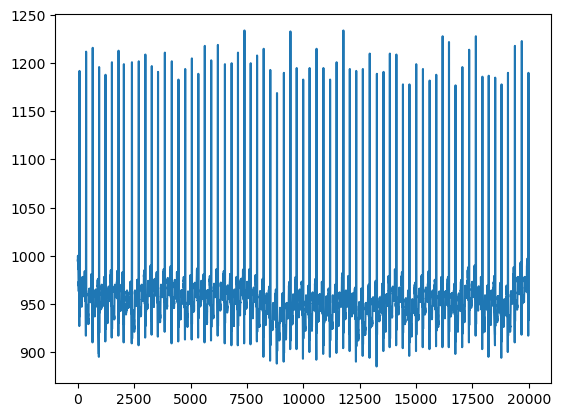

In [7]:
signal.visualize()

In [8]:
parameters = {
    'filter':
    {'cutoff' : [0.75, 3.5], 'sample_rate' : 100, 'order' : 3, 'filtertype' : 'bandpass'},
    'peaks':
    {'height' : 20}
}

In [9]:
signal.set_parameters(parameters)

Parameters saved


In [10]:
signal._filtering()

array([ 2.93669972,  3.29570765,  3.67201131, ..., 46.85395203,
       40.8126148 , 34.54963788])

In [11]:
signal._signal_find_peaks()

array([   77,   370,   663,   947,  1231,  1515,  1809,  2045,  2403,
        2706,  2998,  3283,  3560,  3863,  4171,  4466,  4765,  5060,
        5347,  5634,  5918,  6214,  6527,  6824,  7106,  7391,  7670,
        7953,  8246,  8539,  8837,  9141,  9431,  9710,  9998, 10282,
       10591, 10894, 11192, 11480, 11781, 12066, 12350, 12645, 12950,
       13267, 13562, 13842, 14131, 14423, 14711, 15011, 15310, 15607,
       15900, 16183, 16465, 16755, 17058, 17358, 17657, 17947, 18227,
       18514, 18796, 19081, 19388, 19693, 19926, 19992], dtype=int64)

In [12]:
signal._calculate_RR_intervals()

array([293, 293, 284, 284, 284, 294, 236, 358, 303, 292, 285, 277, 303,
       308, 295, 299, 295, 287, 287, 284, 296, 313, 297, 282, 285, 279,
       283, 293, 293, 298, 304, 290, 279, 288, 284, 309, 303, 298, 288,
       301, 285, 284, 295, 305, 317, 295, 280, 289, 292, 288, 300, 299,
       297, 293, 283, 282, 290, 303, 300, 299, 290, 280, 287, 282, 285,
       307, 305, 233,  66], dtype=int64)

In [13]:
signal.feature_extraction()

[288.6231884057971, 31.077323597890175, 66, 358]

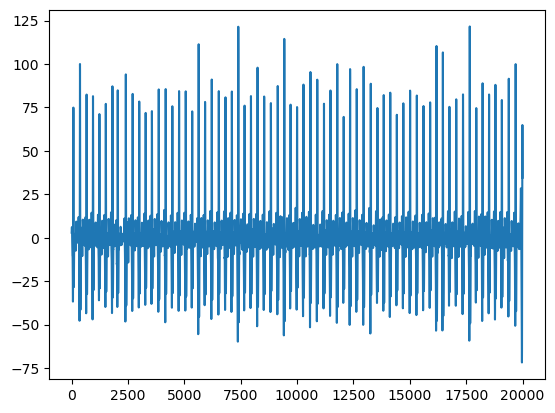

In [14]:
signal.visualize('filtered')

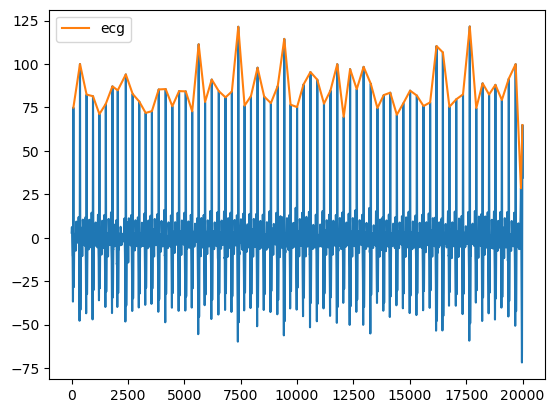

In [15]:
signal.visualize('peaks')

### Image processing

In [16]:
image = ImageProcessing('chest-xray.TIF')

In [17]:
image.get_shape()

(493, 600)

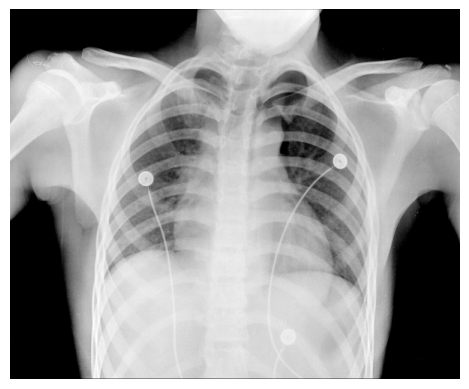

In [18]:
image.visualize()

In [19]:
image._create_gabor_filter([0.25, np.pi, 1])

Filter saved


In [20]:
image._filtering()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [21]:
image.feature_extraction()

[41.113566599053414, 670.1179849805205]

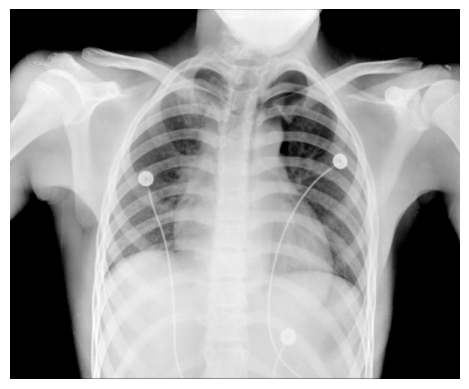

In [22]:
image.visualize('filtered')

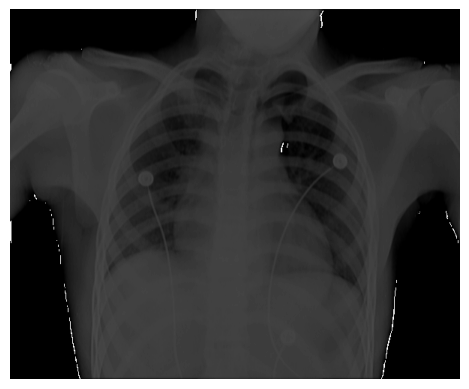

In [23]:
image.visualize('convolved')

## Задача * "Классификатор"

В классе BaseProcessing реализовать метод:
* `get_predict(features, etalons_features)` — метод, в котором осуществляется классификация на основе рассчета Евклидова расстояния между features изображения или сигнала и эталонными значениями признаков (etalons_features) каждого класса изображений или сигналов. Классификация осуществляется следующим образом: полученные Евклидовы расстояния ранжируются в порядке возрастания. Чем меньше Евклидово расстояние, тем более похожим на эталонное изображение считается наше изображение. Выбирается индекс соответствуюших эталонных признаков, которые и являются номером класса. Эталонных класса 2, т.е. возвращается 0 или 1, т.е. класс к которому относится изображение/сигнал.

Классы SignalProcessing и ImageProcessing наследуют реализованный метод get_predict.

Продемонстрировать вызов метода в классах

Эталонные признаки (etalons_features) могут подаются в формате списка:
[[1, 8], [5, 0.5]] -> тогда класс вернуть по индексу

или в формате словаря [{'features': [1, 8], 'class': 0}, {'features': [5, 0.5], 'class': 1}]

In [24]:
etalons_features = [[1, 8], [5, 0.5]]
print(f'Signal class: {signal.get_predict(etalons_features)}')
print(f'Image class: {image.get_predict(etalons_features)}')

Signal class: 1
Image class: 1


In [25]:
etalons_features = [{'features': [1, 8], 'class': 0}, {'features': [5, 0.5], 'class': 1}]
print(f'Signal class: {signal.get_predict(etalons_features)}')
print(f'Image class: {image.get_predict(etalons_features)}')

Signal class: 1
Image class: 1
